In [1]:
from typing import Any
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig, GPT2Model
from transformers import get_linear_schedule_with_warmup
from transformers import Trainer, TrainingArguments

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from transformers import DataCollatorForLanguageModeling
from torch.nn import DataParallel
import pandas as pd
import random

import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM

from bertviz import head_view
from bertviz.neuron_view import show
from rdkit import Chem
import os

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/anaconda3/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Setting `pad_token_id` to `eos_token_id`:30 for open-end generation.


C1CCCC(CC1)C(=O)N2CCC3(CC2)C[NH+](C3)[C@@H]4CCNC4=O


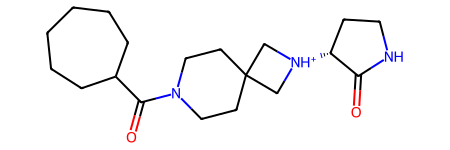

In [2]:
torch.cuda.set_device(0)
device = "cuda"
prompt = "<S>C1CCCC"

tokenizer = AutoTokenizer.from_pretrained('./zinc20M_gpt2_tokenizer')
model = GPT2LMHeadModel.from_pretrained('./model_save_path_zinc20/checkpoint-4468000', output_attentions=True)
model.to(device)
model.eval()

# 對提示語進行編碼，並生成注意力掩碼
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'left'
encoding = tokenizer(
    prompt, return_tensors="pt", truncation=True, max_length=128, add_special_tokens=False)
# print(encoding)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

output_text = model.generate(input_ids, attention_mask=attention_mask, top_k=3, top_p=0.95, max_length=128, do_sample=True, num_return_sequences=1, eos_token_id=30)
generate = tokenizer.decode(output_text[0], skip_special_tokens=True)
clean_smile = generate.replace("<S>", "")
clean_smile = clean_smile.replace("<L>", "")
m = Chem.MolFromSmiles(clean_smile)
print(clean_smile)
m

In [6]:
# 指定smiles
# generate = "<S>CC(C)Oc1cc(ccc1Br)Nc2c3cc(c(cc3ncn2)OCCOC)OCCOC<L>"
encoding = tokenizer(
    generate, return_tensors="pt", truncation=True, max_length=128, add_special_tokens=False)
outputs = model(input_ids)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0]) 

In [7]:
# smiles 怎麼拆分
for num, i in enumerate(input_ids[0]):
    encode = tokenizer.decode(input_ids[0][num], skip_special_tokens=True)
    print(encode)

<
S
>
C
1
CCCC
(
CC
1
)
C
(=
O
)
N
2
CCC
3
(
CC
2
)
C
[
NH
+](
C
3
)[
C
@@
H
]
4
CCNC
4
=
O
<
L
>


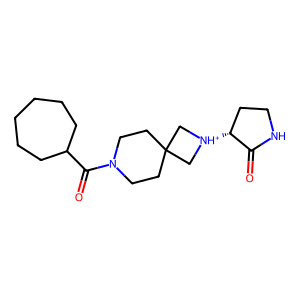

In [8]:
from rdkit import Chem
from rdkit.Chem import Draw
generate = generate.replace('<S>', '')
generate = generate.replace('<L>', '')

m = Chem.MolFromSmiles(generate)
Draw.MolToImage(m, size=(300, 300))

In [12]:
from transformers import utils
from bertviz import model_view

utils.logging.set_verbosity_error()  # Suppress standard warnings
attention = outputs['attentions']  # Retrieve attention from model outputs
delete_token = tuple((t.clone()[:, :, 3:-3, 3:-3] ) * 5 + 0.01 for t in attention) #delete special token



In [14]:
head_view(delete_token, tokens[3:-3])
# head_view(attention, tokens)


<IPython.core.display.Javascript object>